# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Build a Traffic Sign Recognition Classifier

This Notebook contain the process along with the code used in implementing the steps required to complete this project. This Notebook is accompanied with a [writeup](writeup.md) which is included as a separate markdown file. This Notebook along with a HTML copy and the write-up completes the requirements of the documents to be completed as recommended in the [rubric](https://review.udacity.com/#!/rubrics/481/view).


### Import the required Libraries

In [1]:
import tensorflow as tf
import pickle # To Load pickled data
import numpy as np
import pandas as pd
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline 
import time
import glob


import os
import copy
import cv2
from skimage import transform
from skimage.transform import warp, SimilarityTransform, AffineTransform
from skimage import exposure
from sklearn.utils import shuffle
from numpy import random

---
## Step 0: Load The Data

Data to be used is provided in a pickle file in a separate folder.

In [2]:
training_file = "../data/train.p"
validation_file="../data/valid.p"
testing_file = "../data/test.p"
signfile = "signnames.csv"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
df_signs = pd.read_csv(signfile)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### 1.1 Basic Summary of the Data Set

In [3]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train.shape[1:] # or use X_train[0].shape

# Unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### 1.2 A quick Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

Let us quickly see a random image

Label  4
Speed limit (70km/h)


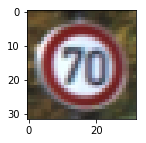

In [4]:
indx = random.randint(0, n_train)
print("Label ", y_train[indx])
print(df_signs["SignName"][y_train[indx]])
image = X_train[indx]
plt.figure(figsize=(2,2))
plt.imshow(image)
plt.show()


 Let us also glance through an image from each of the 43 classes

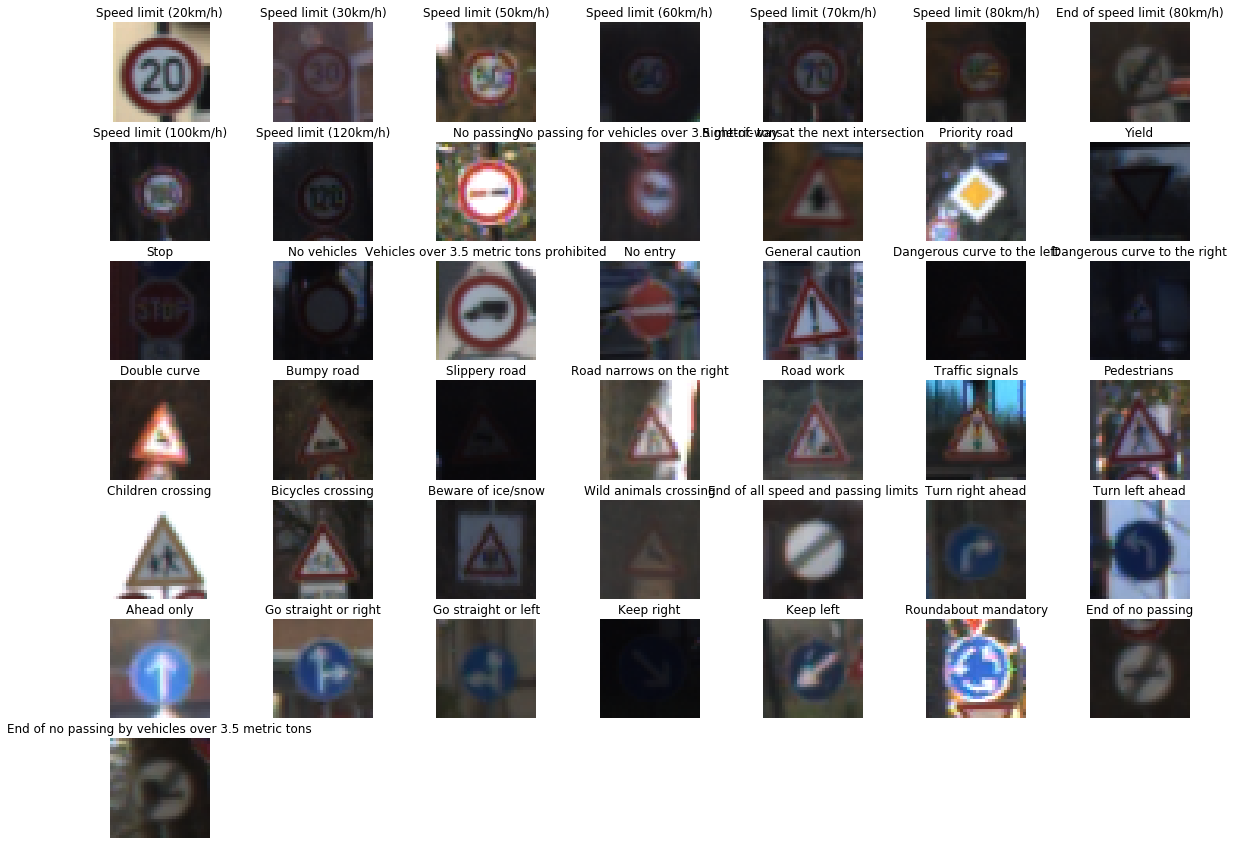

In [5]:
fig=plt.figure(figsize=(20, 15))
columns = 7
rows = 7
for i in range(0, 43):
    X_first = ((X_train[y_train == i])[0])
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(X_first)
    plt.axis('off')
    plt.title((df_signs["SignName"][i]))
plt.show()

### 1.3 How does the distribution of each CLASS in the Train/Test/Validate datasets look like?

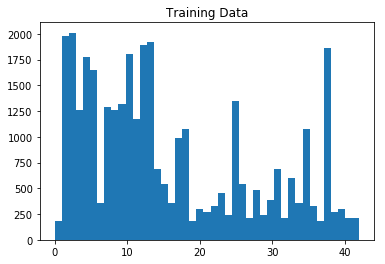

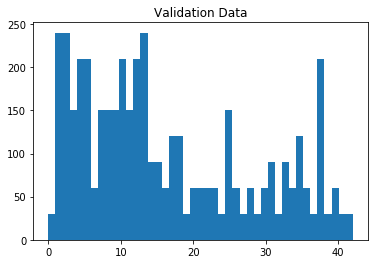

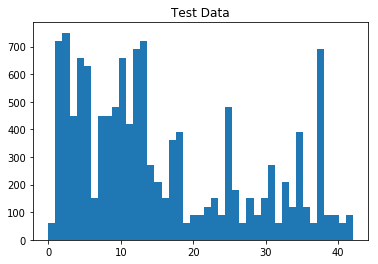

In [6]:

plt.hist(y_train, bins=43)
plt.title("Training Data")
plt.show()
plt.hist(y_valid, bins=43)
plt.title("Validation Data")
plt.show()
plt.hist(y_test, bins=43)
plt.title("Test Data")
plt.show()

## 2 Pre-process the Data Set.

We are performing the following pre-processing steps to address some of the points mentioned above.

1. Norrmalization of the images along with histogram equalization
2. Image Augmentation to handled imbalanced class
    * Brightness Augmentation
    * Image rotation
    * Translation
    * Affine Trnasformation

Reference : [Link1](https://github.com/sharathsrini/Traffic-Sign-Classifier/) and [Link2](https://github.com/vxy10/ImageAugmentation)

### 2.1 Before we start, let us shuffle the dataset.

In [7]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

### 2.2 Norrmalization of the images along with histogram equalization

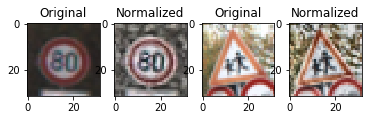

In [8]:
def equalize_histogram(image):
    image = image.astype(np.uint8)
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
    # equalize the histogram of the Y channel
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
    image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])
    
    # convert the YUV image back to RGB format
    image_output = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
    return image_output

def normalization(imag):
    out = np.empty(shape=imag.shape)
    a = 0.1
    b = 0.9
    for i, img in enumerate(imag):
        temp = equalize_histogram(img)
        X_max = np.amax(temp)
        X_min = np.amin(temp)
        out[i] = a + (temp - X_min)*(b - a)/(X_max - X_min)
    return out


# Testing out a Normalized image
indx = random.randint(0, n_train-2)
image = X_train[indx:indx+2]
temp =  normalization(X_train[indx:indx+2])

f, axes = plt.subplots(1,4)
axes[0].imshow(image[0])
axes[0].set_title("Original")
axes[1].imshow(temp[0])
axes[1].set_title("Normalized")
axes[2].imshow(image[1])
axes[2].set_title("Original")
axes[3].imshow(temp[1])
axes[3].set_title("Normalized")
plt.show()

### 2.3 Generating variants of the image using Augmentation
Details of each step ( **brightness, rotation, translation & affine-transform**) is included in comments. Finally we have _image augment()_ function which randomly calls a combination of these functions.

_set augment()_ - applies the _image augment()_ to the enntire array

_settings for augment balanced()_ - creates a balanced dataset of the augmented images.


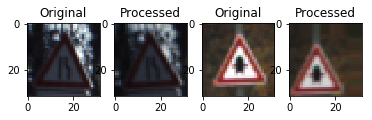

In [9]:

# augment_brightness(image) - changes image brightness by a factor between 0.25 and 1.0 using opencv library
def augment_brightnessX(image):
    image0 = image.astype(np.uint8)
    image1 = cv2.cvtColor(image0,cv2.COLOR_RGB2HSV)
    random_bright = np.random.uniform(0.25, 1)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

#Alternate option to Augment Brightness
def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

# rotate_20_rand(X) - rotates image by random (between -20 and 20 degrees) angle using skimage.transform
def rotate_20_rand(X):
    angl = np.random.uniform(-15, 15)
    result = 255*transform.rotate(X, angle=angl, mode='edge')
    result = result.astype(np.uint8)
    return result

# translation(X) - translates image by $\pm$ 10 pixels using skimage.transform
def translation(X):
    a = np.random.uniform(-5, 5)
    b = np.random.uniform(-5, 5)
    result = 255*warp(X, transform.SimilarityTransform(translation=(a,b)),mode='edge')
    result = result.astype(np.uint8)
    return result

# affine_transform(X) - applies affine transform from skimage.transform with randomly chosen parameters for shear angle and scale
def affine_transform(X):
    sc_a = np.random.uniform(0.8, 1.2)
    sc_b = np.random.uniform(0.8, 1.2)
    shr = np.random.uniform(-0.2, 0.2)
    result = 255*warp(X, transform.AffineTransform(scale=(sc_a, sc_b), shear=shr), mode='edge')
    result = result.astype(np.uint8)
    return result

# image_augment(X) - modify image by combining funcitons above
def image_augment(X):
    n = np.random.randint(1,6)
    if n == 1:
        result = affine_transform(augment_brightness(X)).astype(np.uint8)
    elif n == 2:
        result = translation(augment_brightness(X)).astype(np.uint8)
    elif n == 3:
        result = rotate_20_rand(augment_brightness(X)).astype(np.uint8)
    elif n == 4:
        result = affine_transform(translation(X)).astype(np.uint8)
    elif n == 5:
        result = translation(rotate_20_rand(X)).astype(np.uint8)
    else:
        result = rotate_20rand(affine_transform(X)).astype(np.uint8)
    #result = result.astype(np.uint8)
    return result

# applies the image augment() to the enntire array
def set_augment(X):
    aug_X = np.empty(shape=X.shape, dtype=np.uint8)
    for i, img in enumerate(X):
        aug_X[i] = image_augment(img)
    return aug_X

# creates a balanced dataset of 'N' augmented images.
def settings_for_augment_balanced(X, y, N):
    labels = np.unique(y)
    aug_X_l = []
    aug_y_l = []
    for label in labels:
        label_indices = np.where(y==label)[0]
        noe = len(label_indices)
        if (N-noe < 0):
            # print("No augmentation needed, noe = ", noe)
            continue
        aug_X = np.empty([N-noe, 32, 32, 3], dtype=np.uint8)
        aug_y = np.empty([N-noe], dtype=np.uint8)
        i = 0
        while(N - noe > 0):
            aug_X[i] = image_augment(X[np.random.choice(label_indices)])
            aug_y[i] = label
            noe+=1
            i+=1
        aug_X_l.append(aug_X)
        aug_y_l.append(aug_y)
    return np.vstack(aug_X_l), np.hstack(aug_y_l)



# Testing out a Processed image
indx = random.randint(0, n_train-2)
image = X_train[indx:indx+2]
temp =  set_augment(X_train[indx:indx+2])

f, axes = plt.subplots(1,4)
axes[0].imshow(image[0])
axes[0].set_title("Original")
axes[1].imshow(temp[0])
axes[1].set_title("Processed")
axes[2].imshow(image[1])
axes[2].set_title("Original")
axes[3].imshow(temp[1])
axes[3].set_title("Processed")
plt.show()

### 2.4 Generating new image data by applying the Normalization and  Augmentation

In [10]:
data_train_list = []
label_train_list = []

print("Started...")

X_bal, y_bal = settings_for_augment_balanced(X_train, y_train, N=2000)

data_train_list.append(normalization(np.vstack((X_train, X_bal))))
label_train_list.append(np.hstack((y_train, y_bal)))

#data_train_list.append(normalization(X_train))
#label_train_list.append(y_train)

X_valid = normalization(X_valid)
X_test = normalization(X_test)

print('Done.')


Started...
Done.


----

## Step 3: Design and Test the Model Architecture

In this step, we shall Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point and used here as a template. The LeNet-5 solution from the lecture is quite robust and we can expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### 3.1 Model Architecture

We are defining the hyper-parms for our model here along with the Feature & Label variables .

In [11]:
EPOCHS = 50
BATCH_SIZE = 128
DROP_OUT = 0.5

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)
learning_rate = tf.placeholder(tf.float32, shape=[])

rate = 0.001

We are implementing the LeNet-5 implementation as shown in the classroom at the end of the CNN lesson. The LeNet-5 solution from the lecture is quite robust and we can expect a good validation set accuracy by default. Along with our pre-processing of the data, the accuracy is expected to go up further.

In [13]:

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1   
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    filter_weights = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    filter_bias = tf.Variable(tf.zeros(6))
    L1 = tf.nn.conv2d(x, filter_weights, strides=[1, 1, 1, 1], padding='VALID')
    L1 = tf.nn.bias_add(L1, filter_bias)

    # Activation.
    L1 = tf.nn.relu(L1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    filter_weights = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    filter_bias = tf.Variable(tf.zeros(16))
    L2 = tf.nn.conv2d(L1, filter_weights, strides=[1, 1, 1, 1], padding='VALID')
    L2 = tf.nn.bias_add(L2, filter_bias)
    
    # Activation.
    L2 = tf.nn.relu(L2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    FLT = flatten(L2)
    #FLT   = tf.nn.dropout(FLT, keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    filter_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    filter_bias = tf.Variable(tf.zeros(120))
    FC1 = tf.add(tf.matmul(FLT, filter_weights), filter_bias)
    
    
    # Activation.
    FC1 = tf.nn.relu(FC1)
    # FC1   = tf.nn.dropout(FC1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    filter_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    filter_bias = tf.Variable(tf.zeros(84))
    FC2 = tf.add(tf.matmul(FC1, filter_weights), filter_bias)
    
    # Activation.
    FC2 = tf.nn.relu(FC2)
    # FC2   = tf.nn.dropout(FC2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    filter_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    filter_bias = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(FC2, filter_weights), filter_bias)
    
    return logits


### 3.2 Training Pipeline

Here we define the Training pipeline. 

The calculated 'logits' are evaluated for the least cross-entropy. 
AdamOptimizer is generally recommended to have better results then SGD

In [14]:

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

### 3.3 Model Evaluation

Function to evaluate the model against the Validation set for each epoch.

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### 3.4 Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [16]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        batch_index = np.random.randint(0, len(data_train_list))
        X_train_aug = data_train_list[batch_index]
        y_train_aug = label_train_list[batch_index]
        X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)
        num_examples = len(X_train_aug)
        
        if (i == (EPOCHS//2)):
            rate = 0.0001
            print("Learning rate switched to: ", rate)
        elif (i == (3 * (EPOCHS//4))):
            rate = 0.00001
            print("Learning rate switched to: ", rate) 

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_aug[offset:end], y_train_aug[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROP_OUT, learning_rate: rate})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} Training Accuracy: {:.3f}, Validation Accuracy = {:.3f}".format(i+1, training_accuracy, validation_accuracy))
        
    saver.save(sess, './model/lenet')
    print("Model saved")

Training...

EPOCH 1 Training Accuracy: 0.643, Validation Accuracy = 0.823
EPOCH 2 Training Accuracy: 0.689, Validation Accuracy = 0.859
EPOCH 3 Training Accuracy: 0.739, Validation Accuracy = 0.887
EPOCH 4 Training Accuracy: 0.747, Validation Accuracy = 0.901
EPOCH 5 Training Accuracy: 0.776, Validation Accuracy = 0.911
EPOCH 6 Training Accuracy: 0.794, Validation Accuracy = 0.922
EPOCH 7 Training Accuracy: 0.781, Validation Accuracy = 0.922
EPOCH 8 Training Accuracy: 0.806, Validation Accuracy = 0.932
EPOCH 9 Training Accuracy: 0.788, Validation Accuracy = 0.916
EPOCH 10 Training Accuracy: 0.790, Validation Accuracy = 0.932
EPOCH 11 Training Accuracy: 0.789, Validation Accuracy = 0.938
EPOCH 12 Training Accuracy: 0.810, Validation Accuracy = 0.937
EPOCH 13 Training Accuracy: 0.789, Validation Accuracy = 0.934
EPOCH 14 Training Accuracy: 0.799, Validation Accuracy = 0.939
EPOCH 15 Training Accuracy: 0.816, Validation Accuracy = 0.933
EPOCH 16 Training Accuracy: 0.826, Validation Accur

#### Testing the Model accuracy against the Test set

In [17]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model'))
    
    print("Training Accuracy = {:.3f}".format(evaluate(X_train, y_train)))
    print("Validation Accuracy = {:.3f}".format(evaluate(X_valid, y_valid)))
    print("Test Accuracy = {:.3f}".format(evaluate(X_test, y_test)))
    

INFO:tensorflow:Restoring parameters from ./model/lenet
Training Accuracy = 0.832
Validation Accuracy = 0.948
Test Accuracy = 0.935


---

## Step 4: Test a Model on New Images

To get more insight into how your model is working, we download at five pictures of German traffic signs from the web and used our model to predict the traffic sign type.

The `signnames.csv` was useful as it contains mappings from the class id (integer) to the actual sign name.

### 4.1 Load and Output the Images

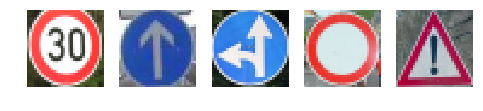

In [18]:
#np.seterr(divide='ignore', invalid='ignore')
resize_images = []
load_images_name = []

test_images = glob.glob('./NewSigns/*')

for fname in test_images:
    image = mpimg.imread(fname)
    resize_image = cv2.resize(image, (32, 32))
    resize_images.append(resize_image)
    load_images_name += [fname]


fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 1
for i in range(0, 5):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(resize_images[i])
    plt.axis('off')
plt.show()


### 4.2 Predict the Sign Type for Each Image

In [19]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model'))
    logits_predicted = sess.run(logits, feed_dict={x: resize_images, keep_prob: 1.0})
    labels_predicted = np.argmax(logits_predicted, axis=1)
    for i in range(len(load_images_name)):
        ipath = load_images_name[i]
        pred = labels_predicted[i]
        iname = df_signs["SignName"][pred]
        print("{0} - Prediction Class: {1} , - {2}".format(ipath, pred, iname))

print()


INFO:tensorflow:Restoring parameters from ./model/lenet
./NewSigns/speed30.png - Prediction Class: 1 , - Speed limit (30km/h)
./NewSigns/ahead.png - Prediction Class: 35 , - Ahead only
./NewSigns/ahead_left.png - Prediction Class: 30 , - Beware of ice/snow
./NewSigns/NoVeh.png - Prediction Class: 15 , - No vehicles
./NewSigns/genCaution.png - Prediction Class: 18 , - General caution



### 4.3 Analyze Performance

In [20]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model'))
    
    #Based on above cell output.
    #y_test = [correct_label_for_test_7, correct_label_for_test_1, and so on .....]
    y_test = [1,35,37,15,18]
    load_new_images_accuracy = evaluate(resize_images, y_test)
    print("Test Accuracy on new loaded images = {:.3f}".format(load_new_images_accuracy))
    

INFO:tensorflow:Restoring parameters from ./model/lenet
Test Accuracy on new loaded images = 0.800


### 4.4 Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k). 


In [21]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

softmax_result = tf.nn.softmax(logits_predicted)

with tf.Session() as sess:
    top_five_softmax = sess.run(tf.nn.top_k(softmax_result, k=5))
    print("Top 5 Softmax Probabilities For Each Image :")
    print()
    for x in range(len(load_images_name)):
        print("{0}:".format(load_images_name[x]))
        print()
        for y in range(5):
            predclass = top_five_softmax[1][x][y]
            predperc = top_five_softmax[0][x][y]*100
            iname = df_signs["SignName"][predclass]
            print("{:d}: {} - {:.2f}%".format(predclass, iname, predperc))
        print()

Top 5 Softmax Probabilities For Each Image :

./NewSigns/speed30.png:

1: Speed limit (30km/h) - 100.00%
0: Speed limit (20km/h) - 0.00%
2: Speed limit (50km/h) - 0.00%
4: Speed limit (70km/h) - 0.00%
5: Speed limit (80km/h) - 0.00%

./NewSigns/ahead.png:

35: Ahead only - 100.00%
34: Turn left ahead - 0.00%
33: Turn right ahead - 0.00%
36: Go straight or right - 0.00%
37: Go straight or left - 0.00%

./NewSigns/ahead_left.png:

30: Beware of ice/snow - 90.14%
34: Turn left ahead - 9.82%
20: Dangerous curve to the right - 0.03%
35: Ahead only - 0.01%
37: Go straight or left - 0.00%

./NewSigns/NoVeh.png:

15: No vehicles - 100.00%
41: End of no passing - 0.00%
5: Speed limit (80km/h) - 0.00%
13: Yield - 0.00%
32: End of all speed and passing limits - 0.00%

./NewSigns/genCaution.png:

18: General caution - 100.00%
27: Pedestrians - 0.00%
22: Bumpy road - 0.00%
26: Traffic signals - 0.00%
24: Road narrows on the right - 0.00%



Top 5 Softmax Probabilities For Each Image :



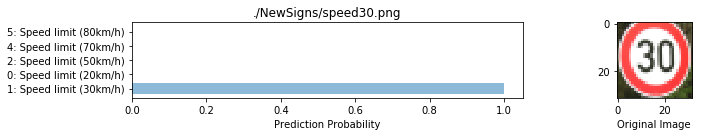

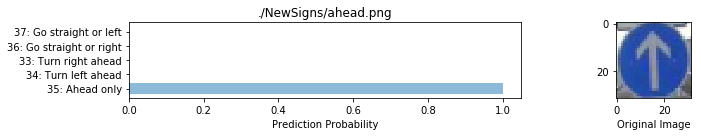

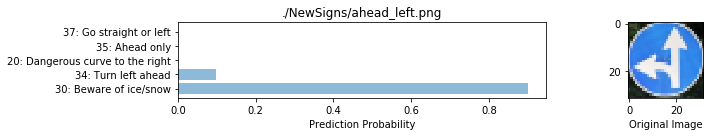

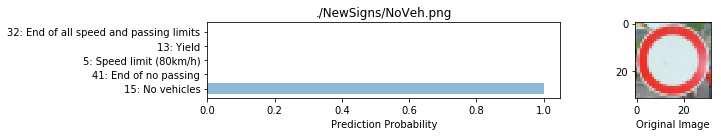

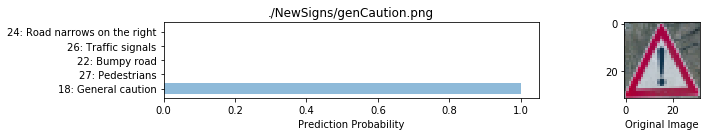

In [22]:

def plot_figures(imgname, ofigure, pclass, pperc, nrows = 1, ncols=2):
    fig=plt.figure(figsize=(12, 2))
    fig.add_subplot(nrows, ncols, 2)
    plt.imshow(ofigure)
    plt.xlabel('Original Image')

    fig.add_subplot(nrows, ncols, 1)
    y_pos = np.arange(len(pclass))
    plt.barh(y_pos, pperc, align='center', alpha=0.5)
    plt.yticks(y_pos, pclass)
    plt.xlabel('Prediction Probability')
    plt.title(imgname)
    plt.tight_layout()
    plt.show()

    
softmax_result = tf.nn.softmax(logits_predicted)

with tf.Session() as sess:
    top_five_softmax = sess.run(tf.nn.top_k(softmax_result, k=5))
    print("Top 5 Softmax Probabilities For Each Image :")
    print()
    for x in range(5):  # len(load_images_name)
        imgname = load_images_name[x]
        o_figure = resize_images[x]
        predclassARR = []
        predpercARR = []
        for y in range(5):
            predclass = top_five_softmax[1][x][y]
            predperc = top_five_softmax[0][x][y] #*100
            iname = df_signs["SignName"][predclass]
            predclassARR.append(str(predclass) + ": " + iname)
            predpercARR.append(predperc)
        plot_figures(imgname, o_figure, predclassARR, predpercARR, 1, 2)

        


### Project Writeup

This concludes the code implementation of this project. I have documented the results in a project writeup which can be found [here](writeup.md).

---
---
---

#### The below additional optional step was not performed at this time due to time constraint (deadline) in submitting this project.

This step will be re-visited later

---

### Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

